In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Image
import pickle

In [2]:
path = 'results/nLE_nLED_cifer10/'

## load data

In [3]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
print(len(X_train))
print(len(X_test))
print(X_train.shape)

50000
10000
(50000, 32, 32, 3)


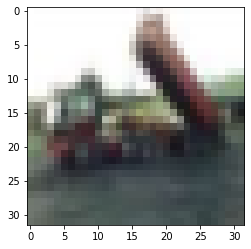

In [5]:
imgplot = plt.imshow(X_train[2])
plt.show()

## preprocessing/F.E.

## set parameter

# imageshuffle

In [6]:
train_data = pd.DataFrame({'x':[*X_train],'y':[*Y_train]})
test_data = pd.DataFrame({'x':[*X_test],'y':[*Y_test]})
# train_data = train_data.loc[train_data['y']<5]
# test_data = test_data.loc[test_data['y']<5]
data = [train_data,test_data]

In [7]:
for d in data:
    d['nor_x'] = d['x'].apply(lambda x:x/255)
    d['cate_y']=[*tf.keras.utils.to_categorical(d['y'])]

In [8]:
data[0]

,x,y,nor_x,cate_y
0,"[[[59, 62, 63], [43, 46, 45], [50, 48, 43], [6...",[6],"[[[0.23137254901960785, 0.24313725490196078, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,"[[[154, 177, 187], [126, 137, 136], [105, 104,...",[9],"[[[0.6039215686274509, 0.6941176470588235, 0.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[255, 255, 255], [253, 253, 253], [253, 253,...",[9],"[[[1.0, 1.0, 1.0], [0.9921568627450981, 0.9921...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[[28, 25, 10], [37, 34, 19], [38, 35, 20], [4...",[4],"[[[0.10980392156862745, 0.09803921568627451, 0...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[[170, 180, 198], [168, 178, 196], [177, 185,...",[1],"[[[0.6666666666666666, 0.7058823529411765, 0.7...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
49995,"[[[145, 161, 194], [151, 166, 199], [156, 171,...",[2],"[[[0.5686274509803921, 0.6313725490196078, 0.7...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49996,"[[[255, 245, 132], [254, 247, 134], [255, 249,...",[6],"[[[1.0, 0.9607843137254902, 0.5176470588235295...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
49997,"[[[35, 178, 235], [40, 176, 239], [42, 176, 24...",[9],"[[[0.13725490196078433, 0.6980392156862745, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49998,"[[[189, 211, 240], [186, 208, 236], [185, 207,...",[1],"[[[0.7411764705882353, 0.8274509803921568, 0.9...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
train_x =np.array([[*a]for a in data[0]['nor_x']])
train_y =np.array([[*a]for a in data[0]['cate_y']])
test_x =np.array([[*a]for a in data[1]['nor_x']])
test_y =np.array([[*a]for a in data[1]['cate_y']])

## Training

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input,\
                                    Lambda,MaxPooling2D, GlobalAveragePooling2D,\
                                    Add, Concatenate,BatchNormalization
from tensorflow.keras.models import Model

from moudule.padding import PaddingReplicate2D
from moudule.pixelshuffle import PixelShuffle
from moudule.pixelshuffle import PixelShuffle_calc, PixelShuffle_shape

from keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import CSVLogger

In [11]:
def resnet1(input_shape, nb_classes=10):
    p1 = PaddingReplicate2D((1,1))
    inp = Input(shape=input_shape)
    x = inp

    # block0 ####################################################
#     x = BatchNormalization() (x)
#     x = Conv2D( 4*4*3, (4,4), padding='valid', strides=(4,4), kernel_initializer='he_normal' ) (x)
#     x = Activation('relu') (x)
#     # 8x8x48
    
#     x = BatchNormalization() (x)
#     x = Conv2D( 4*4*3, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
#     x = Activation('relu') (x)
#     # 8x8x48

#     x = BatchNormalization() (x)
#     x = Conv2D( 4*4*3, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
#     x = Activation('relu') (x)
#     # 8x8x48

#     x = BatchNormalization() (x)
#     x = Conv2D( 4*4*32, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
#     x = PixelShuffle( x, 4 )
    x = Conv2D(32, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
    # 32x32x32
    
    # block1 ####################################################
    f = 32
    fs = 16
    for i in range(2):
        f0 = f
        f = f+fs
        r = x[:]
        r = BatchNormalization() (r)
        r = Activation('relu') (r)
        r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))

        r = BatchNormalization() (r)
        r = Activation('relu') (r)
        r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))
        
        r = Dropout(0.25) (r)
        # r0 = Lambda(lambda x: x[:,:,:,:f0], lambda s: (s[0], s[1], s[2], f0)) (r)
        # r1 = Lambda(lambda x: x[:,:,:,f0:], lambda s: (s[0], s[1], s[2], fs) ) (r)
        r0 = r[:,:,:,:f0]
        r1 = r[:,:,:,f0:]

        x = Add() ([x,r0])
        x = Concatenate(axis=-1) ([x,r1])
    # 32x32x64
    
    x = MaxPooling2D(pool_size=(2, 2)) (x)
    # 16x16x64
    # block2 ####################################################
    f = 64
    fs = 32
    for i in range(2):
        f0 = f
        f = f+fs
        r = x

        r = BatchNormalization() (r)
        r = Activation('relu') (r)
        r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))

        r = BatchNormalization() (r)
        r = Activation('relu') (r)
        r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))

        r = Dropout(0.25) (r)

        # r0 = Lambda(lambda x: x[:,:,:,:f0], lambda s: (s[0], s[1], s[2], f0) ) (r)
        # r1 = Lambda(lambda x: x[:,:,:,f0:], lambda s: (s[0], s[1], s[2], fs) ) (r)

        r0 = r[:,:,:,:f0]
        r1 = r[:,:,:,f0:]
        x = Add() ( [x,r0] )
        x = Concatenate(axis=-1) ([x,r1])

        f0 = f
    # 16x16x128

    x = MaxPooling2D(pool_size=(2, 2)) (x)
    # 8x8x128

    # block3 ####################################################
    f = 128
    fs = 64
    for i in range(2):
        f0 = f
        f = f+fs
        r = x

        r = BatchNormalization() (r)
        r = Activation('relu') (r)
        r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))

        r = BatchNormalization() (r)
        r = Activation('relu') (r)
        r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))

        r = Dropout(0.25) (r)

        # r0 = Lambda(lambda x: x[:,:,:,:f0], lambda s: (s[0], s[1], s[2], f0) ) (r)
        # r1 = Lambda(lambda x: x[:,:,:,f0:], lambda s: (s[0], s[1], s[2], fs) ) (r)

        r0 = r[:,:,:,:f0]
        r1 = r[:,:,:,f0:]
        x = Add() ( [x,r0] )
        x = Concatenate(axis=-1) ([x,r1])

        f0 = f
    # 8x8x256

    x = MaxPooling2D(pool_size=(2, 2)) (x)
    # 4x4x256

    # block4 ####################################################
    x = Dropout(0.5) (x)
    x = Conv2D( 512, (1,1), padding='valid', kernel_initializer='he_normal', activation='relu' ) (x)

    x = Dropout(0.5) (x)
    x = Conv2D( nb_classes, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
    x = GlobalAveragePooling2D() (x)
    x = Activation('softmax') (x)

    return Model(inputs=inp, outputs=x)

In [12]:
model = resnet1(input_shape=[32,32,3], nb_classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   128         ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 32, 32, 32)  0           ['conv2d[0][0]']                 
 ingOpLambda)                                                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['tf.__operators__.getitem[0]

                                                                  'tf.__operators__.getitem_5[0][0
                                                                 ]']                              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['concatenate_1[0][0]']          
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 16, 16, 64)  256         ['max_pooling2d[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_4[0][0]']  
                                                                                                  
 conv2d_5 

 tf.__operators__.getitem_10 (S  (None, 8, 8, 128)   0           ['dropout_4[0][0]']              
 licingOpLambda)                                                                                  
                                                                                                  
 add_4 (Add)                    (None, 8, 8, 128)    0           ['max_pooling2d_1[0][0]',        
                                                                  'tf.__operators__.getitem_10[0][
                                                                 0]']                             
                                                                                                  
 tf.__operators__.getitem_11 (S  (None, 8, 8, 64)    0           ['dropout_4[0][0]']              
 licingOpLambda)                                                                                  
                                                                                                  
 concatena

Epoch 1/50
782/782 [==============================] - 140s 172ms/step - loss: 1.9503 - accuracy: 0.3610 - val_loss: 2.1220 - val_accuracy: 0.3258
Epoch 2/50
782/782 [==============================] - 132s 169ms/step - loss: 1.2198 - accuracy: 0.5552 - val_loss: 2.0019 - val_accuracy: 0.3078
Epoch 3/50
782/782 [==============================] - 120s 153ms/step - loss: 0.9864 - accuracy: 0.6493 - val_loss: 1.9849 - val_accuracy: 0.4099
Epoch 4/50
782/782 [==============================] - 113s 145ms/step - loss: 0.8219 - accuracy: 0.7095 - val_loss: 1.3627 - val_accuracy: 0.5266
Epoch 5/50
782/782 [==============================] - 118s 151ms/step - loss: 0.7029 - accuracy: 0.7573 - val_loss: 1.0577 - val_accuracy: 0.6213
Epoch 6/50
782/782 [==============================] - 121s 154ms/step - loss: 0.6192 - accuracy: 0.7875 - val_loss: 0.7537 - val_accuracy: 0.7523
Epoch 7/50
782/782 [==============================] - 123s 157ms/step - loss: 0.5588 - accuracy: 0.8101 - val_loss: 1.4693 -

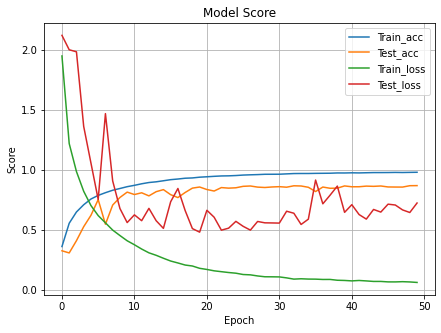

In [13]:
epochs = 50
batch_size = 64
csv_logger = CSVLogger(path+'log/log.csv', append=True, separator=';')

his = model.fit(train_x, 
            train_y, 
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=1,
            validation_data=(test_x, test_y),
            callbacks=[csv_logger]
            )

model.save(path+'model/model'+'.h5')
with open(path+'his/his.pkl', 'wb') as fp:
    pickle.dump(his.history, fp)
    
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)
plt.plot(his.history["accuracy"])
plt.plot(his.history["val_accuracy"])
plt.plot(his.history["loss"])
plt.plot(his.history['val_loss'])
plt.title("Model Score")
plt.ylabel("Score")
plt.xlabel("Epoch")
# ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train_acc", "Test_acc","Train_loss", "Test_loss"], loc="upper right")
plt.grid()
plt.savefig(path+"loss/loss"+".png",dpi=1000)
plt.show()

In [14]:
result = pd.DataFrame({"True_value":data[1]['y']})

In [15]:
pred_y = model.predict( test_x )
result['model'] = [*pred_y]
acc = categorical_accuracy( test_y, pred_y )
np.mean(acc)

0.8691

In [16]:
result.to_pickle(path+'pre_test_result.pkl')